In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from MakeSyntheticSeismic import MakeSeismic, PlotSeis,MakeSeismic_paper
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [41]:
# Generating images 
num_img = 100
clean_signal2, noise2, noisy_signal2 = MakeSeismic(samples=num_img,img_size=256,num_events=10)
clean_signal3, noise3, noisy_signal3 = MakeSeismic(samples=300,img_size=256,num_events=10)

# clean_signal_p, noise_p, noisy_signal_p = MakeSeismic_paper(samples=200,img_size=256)

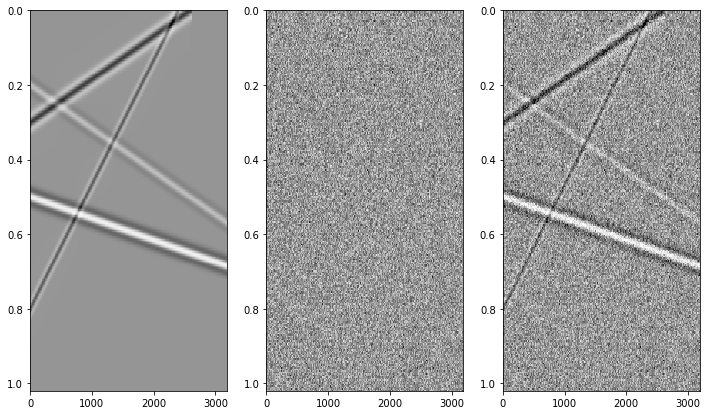

In [42]:
PlotSeis([clean_signal_p,noise_p,noisy_signal_p],num=3)

In [43]:
psnr = []
for i in range(num_img):
    psnr.append(PSNR(clean_signal2[i],noisy_signal2[i]))
print(np.min(psnr),np.max(psnr))

16.17617152431467 25.128224323608592


In [44]:
# Splitting images into windows to pass through the autoencoder if we're using windows 
cs_windows_conv = []
ns_windows_conv = []
n_windows_conv = []

cs_windows = []
ns_windows = []
n_windows = []

win_size = 32
win_size2 = 16
for iImg in range(num_img):
    cs_windows_conv.append(img2windows(clean_signal2[iImg,:,:,0],win_size,win_size))
    ns_windows_conv.append(img2windows(noisy_signal2[iImg,:,:,0],win_size,win_size))
    n_windows_conv.append(img2windows(noise2[iImg,:,:,0],win_size,win_size))

    cs_windows.append(img2windows(clean_signal2[iImg,:,:,0],win_size2,win_size2))
    ns_windows.append(img2windows(noisy_signal2[iImg,:,:,0],win_size2,win_size2))
    n_windows.append(img2windows(noise2[iImg,:,:,0],win_size2,win_size2))


cs_windows_conv = np.array(cs_windows_conv)
ns_windows_conv = np.array(ns_windows_conv)
n_windows_conv = np.array(n_windows_conv)

cs_windows = np.array(cs_windows)
ns_windows = np.array(ns_windows)
n_windows = np.array(n_windows)

In [45]:
# Generating training and testing data
NS_train_wind, NS_test_wind, S_train_wind, S_test_wind = train_test_split(ns_windows,cs_windows, test_size=0.33, random_state = 21)
NS_train_trc, NS_test_trc, S_train_trc, S_test_trc = train_test_split(noisy_signal3,clean_signal3, test_size=0.33, random_state = 21)

# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv_sc,cs_windows_conv_sc, test_size=0.33, random_state = 21)
NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv,cs_windows_conv, test_size=0.33, random_state = 21)

In [46]:
# Custom loss functions

# y_true = target = clean image = X_train
# y_pred = clean output

# max structural similarity index between original image and denoised imaged 
def ssim_loss(y_true, y_pred):
  return 1-reduce_mean(ssim(y_true, y_pred, 1.0, filter_size=5))

In [47]:
# Reshaping images before they go into ANN
NS_train_wind_resh = NS_train_wind.reshape(NS_train_wind.shape[0]*NS_train_wind.shape[1],256)
S_train_wind_resh = S_train_wind.reshape(NS_train_wind.shape[0]*NS_train_wind.shape[1],256)
NS_test_wind_resh = NS_test_wind.reshape(NS_test_wind.shape[0]*NS_test_wind.shape[1],256)
S_test_wind_resh = S_test_wind.reshape(NS_test_wind.shape[0]*NS_test_wind.shape[1],256)


# Splitting out the traces into a single continuous file
NS_train_trc_resh = NS_train_trc.reshape(NS_train_trc.shape[0]*NS_train_trc.shape[1],256)
S_train_trc_resh = S_train_trc.reshape(NS_train_trc.shape[0]*NS_train_trc.shape[1],256)
NS_test_trc_resh = NS_test_trc.reshape(NS_test_trc.shape[0]*NS_test_trc.shape[1],256)
S_test_trc_resh = S_test_trc.reshape(NS_test_trc.shape[0]*NS_test_trc.shape[1],256)

# Reshaping conv windows 
NS_train_conv_resh = NS_train_conv.reshape(NS_train_conv.shape[0]*NS_train_conv.shape[1],NS_train_conv.shape[2],NS_train_conv.shape[3],1)
S_train_conv_resh = S_train_conv.reshape(S_train_conv.shape[0]*S_train_conv.shape[1],S_train_conv.shape[2],S_train_conv.shape[3],1)
NS_test_conv_resh = NS_test_conv.reshape(NS_test_conv.shape[0]*NS_test_conv.shape[1],NS_test_conv.shape[2],NS_test_conv.shape[3],1)
S_test_conv_resh = S_test_conv.reshape(S_test_conv.shape[0]*S_test_conv.shape[1],S_test_conv.shape[2],S_test_conv.shape[3],1)

In [68]:
psnr = []
for i in range(S_train_wind_resh.shape[0]):
    psnr.append(PSNR(S_train_wind_resh[i],NS_train_wind_resh[i]))
print("Training min PSNR = %.2f; Training max PSNR = %.2f" %(np.min(psnr),np.max(psnr)))

Training min PSNR = 5.31; Training max PSNR = 24.53


In [67]:
psnr = []
for i in range(S_test_wind_resh.shape[0]):
    psnr.append(PSNR(S_train_wind_resh[i],NS_train_wind_resh[i]))
print("Testing min PSNR = %.2f; Testing max PSNR = %.2f" %(np.min(psnr),np.max(psnr)))

Testing min PSNR = 5.66; Testing max PSNR = 23.47


In [57]:
# modelUnet = autoencoder("Unet",start_filters=8)
# modelUnetMSE = autoencoder("Unet_NoSc",start_filters=8)
# modelUnetBCE = autoencoder("Unet",start_filters=8)
# modelUpSc = autoencoder("upsc")
# modelUnetNoSc = autoencoder("Unet_NoSc",start_filters=8)

# modelANN_wind.compile(loss='mse',optimizer='adam')

# modelConv3x3 = autoencoder("upsc",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConv3x3_v2 = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConv3x3_SGD = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))



# modelConvUnet = autoencoder("Unet_NoSc",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConvUnet_v2 = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
modelConvUnet_v3_SGD = autoencoder("Unet_NoSc_v3",kernel=(3,3),input_size=(win_size,win_size,1))

# modelConvUnet_v2_SGD = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))

modelANN_trc = autoencoder("ANN")
modelANN_trc_SGD = autoencoder("ANN")

sgd = Adam(lr=0.001)

# modelConv3x3.compile(loss='mse',optimizer='adam')
# modelConv3x3_v2.compile(loss='mse',optimizer='adam')
# modelConv3x3_SGD.compile(loss='mse',optimizer=sgd)

# modelConvUnet.compile(loss='mse',optimizer='adam')
# modelConvUnet_v2.compile(loss='mse',optimizer='adam')
# modelConvUnet_v2_SGD.compile(loss='mse',optimizer=sgd)
modelConvUnet_v3_SGD.compile(loss='mse',optimizer=sgd)


modelANN_trc.compile(loss='mse',optimizer='adam')
modelANN_trc_SGD.compile(loss='mse',optimizer=sgd)



In [58]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [59]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint_callback = ModelCheckpoint(
#     filepath='checkpoint_filepath',
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [61]:
# batch_size= 64
# epochs = 75
# modelANN_trc_SGD_hist = modelANN_trc_SGD.fit(NS_train_wind_resh, S_train_wind_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_wind_resh,S_test_wind_resh),use_multiprocessing=True)

In [18]:
# batch_size= 128
# epochs = 50
# modelConv3x3_hist = modelConv3x3.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [19]:
# batch_size= 128
# epochs = 50
# modelConv3x3_v2_hist = modelConv3x3_v2.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [20]:
# batch_size= 256
# epochs = 40
# modelConvUnet_hist = modelConvUnet.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [21]:
# batch_size= 256
# epochs = 40
# modelConvUnet_v2_hist = modelConvUnet_v2.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [22]:
# batch_size= 256
# epochs = 40
# modelConvUnet_v2_SGD_hist = modelConvUnet_v2_SGD.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [1]:
# batch_size= 256
# epochs = 40
# modelConvUnet_v3_SGD_hist = modelConvUnet_v3_SGD.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [120]:
# batch_size= 128
# epochs = 50
# modelConv3x3_SGD_hist = modelConv3x3_SGD.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [24]:
# _2 = 128 batch size ** best ** 
# _3 = 64 batch size 
# _4 = 128 batch size with new correct noise level input

# currently Conv3x3_v2 and ConvUnet_v3_SGD are my preferred 
# hists = pd.DataFrame(modelANN_trc_hist.history)
# hists["model"]="ANN_trc"
hists = pd.read_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_hist.history),"ConvUpsc_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v2_hist.history),"ConvUpsc_v2_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_hist.history),"ConvUnet_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_hist.history),"ConvUnet_v2_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_SGD_hist.history),"ConvUnet_v2_SGD_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_SGD_hist.history),"ConvUpsc_SGD_100img")

hists= store_hist(hists,pd.DataFrame(modelConvUnet_v3_SGD_hist.history),"ConvUnet_v3_SGD_100img")

# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v3_hist.history),"ConvUpsc_v3_100img")

hists.to_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')


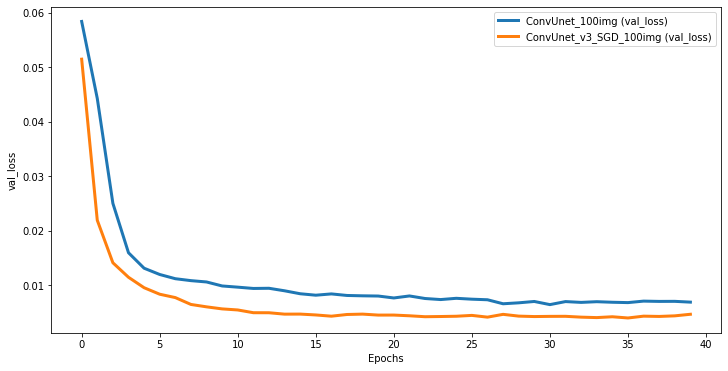

In [27]:
plot_perf(hists,['ConvUnet_100img','ConvUnet_v3_SGD_100img'],['val_loss'])

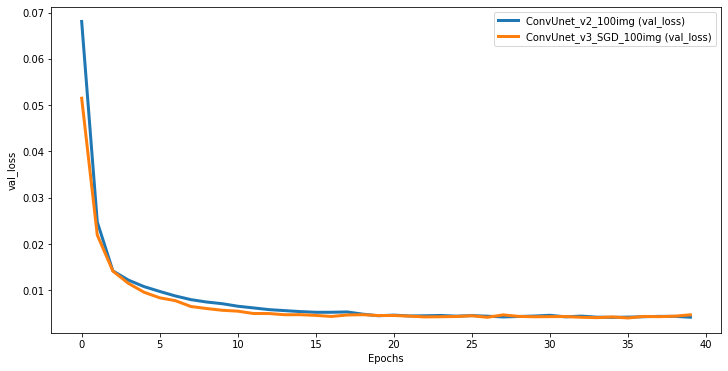

In [29]:
plot_perf(hists,['ConvUnet_v2_100img','ConvUnet_v3_SGD_100img'],['val_loss'])

In [17]:
#v1 = orig
#v2 = smaller, removed one encoder and one decoder layer
# Currently prefer conv3x3_v2 and Unet_v2_SGD

# SGD = using lr = 0.001, converges slightly slower

# modelUnetMSE.save('./models/UnetMSE_16filt')
# modelUnetMSE.save('./models/UnetMSE_8filt')
# modelANN_wind.save('./models/ANN_wind_4')
# modelANN_trc.save('./models/ANN_trc_4')

modelANN_trc_SGD.save('./models/ANN_trc_SGD_p')


# modelConv3x3.save('./models/UpscConv3x3')
# modelConv3x3_v2.save('./models/UpscConv3x3_v2')
# modelConv3x3_SGD.save('./models/UpscConv3x3_SGD')

# modelConvUnet.save('./models/Unet_v1')
# modelConvUnet_v2.save('./models/Unet_v2')
# modelConvUnet_v2_SGD.save('./models/Unet_v2_SGD')
# modelConvUnet_v3_SGD.save('./models/Unet_v3_SGD')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [20]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

model_json = modelANN_trc_SGD.to_json()
with open("./models/modelANN_trc_SGD.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelANN_trc_SGD.save_weights("./models/modelANN_trc_SGD_weights.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
from tensorflow.keras.models import load_model
modelANN_trc = load_model('./models/ANN_trc_4')
modelANN_wind = load_model('./models/ANN_wind_4')
modelConv3x3_v1 = load_model('./models/UpscConv3x3_v2/')
modelConv3x3 = load_model('./models/UpscConv3x3')
modelConv3x3_v2 = load_model('./models/UpscConv3x3_v2')
modelConv3x3_SGD = load_model('./models/UpscConv3x3_SGD')
modelConvUnet = load_model('./models/Unet_v1')
modelConvUnet_v2 = load_model('./models/Unet_v2')
modelConvUnet_v2_SGD = load_model('./models/Unet_v2_SGD')

In [39]:
# Predicting

# pred = modelUnet.predict(NS_test)
# pred2 = modelUnet.predict(ns_test)
# predmse = modelUnetMSE.predict(NS_test_nosc)
# predmse3 = modelUnetMSE.predict(NS_test_nosc)

# pred_upsc = modelUpSc.predict(ns_test)
# pred_nosc = modelUnetNoSc.predict(NS_test_nosc)

# predANN_trc = modelANN_trc_v1.predict(NS_test_trc_resh)
# predANN_trc = modelANN_trc.predict(NS_test_trc_resh)
predANN_trc_SGD = modelANN_trc_SGD.predict(NS_test_trc_resh)


# predANN_wind_v1 = modelANN_wind_v1.predict(NS_test_wind_resh)
# predANN_wind = modelANN_wind.predict(NS_test_wind_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_4x4 = modelConv4x4.predict(NS_test_conv_resh)

predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
predConv_wind_3x3_v2 = modelConv3x3_v2.predict(NS_test_conv_resh)


predConvUnet = modelConvUnet.predict(NS_test_conv_resh)
predConvUnet_v2 = modelConvUnet_v2.predict(NS_test_conv_resh)
predConvUnet_v2_SGD = modelConvUnet_v2_SGD.predict(NS_test_conv_resh)
predConvUnet_v3_SGD = modelConvUnet_v3_SGD.predict(NS_test_conv_resh)

In [40]:
def pred_resh(data,output_size,num_wind,wind_size):

    # Reshaping predictions
    data_resh= data.reshape(int(data.shape[0]/num_wind),num_wind,wind_size,wind_size)

    img = []
    orig_noisy = []
    orig_clean = []
    for iImg in range(data_resh.shape[0]):
        img.append(windows2img(data_resh[iImg],output_size,output_size))
        orig_noisy.append(windows2img(NS_test_conv[iImg],output_size,output_size))
        orig_clean.append(windows2img(S_test_conv[iImg],output_size,output_size))

    img = np.array(img)
    orig_noisy = np.array(orig_noisy)
    orig_clean = np.array(orig_clean)

    return img


In [41]:
decodedimg_conv3x3 = pred_resh(predConv_wind_3x3,output_size=256,num_wind=64,wind_size=32)
decodedimg_conv3x3_v2 = pred_resh(predConv_wind_3x3_v2,output_size=256,num_wind=64,wind_size=32)

decodedimg_convUnet = pred_resh(predConvUnet,output_size=256,num_wind=64,wind_size=32)
decodedimg_convUnet_v2 = pred_resh(predConvUnet_v2,output_size=256,num_wind=64,wind_size=32)
decodedimg_convUnet_v2_SGD = pred_resh(predConvUnet_v2_SGD,output_size=256,num_wind=64,wind_size=32)

decodedimg_convUnet_v3_SGD = pred_resh(predConvUnet_v3_SGD,output_size=256,num_wind=64,wind_size=32)



# decodedimg_ANNwind = pred_resh(predANN_wind,output_size=256,num_wind=256,wind_size=16)

In [44]:
# decodedimg_ANNtrc = predANN_trc.reshape(330,256,256,1)
decodedimg_ANNtrc_SGD = predANN_trc_SGD.reshape(66,256,256,1)
orig_noisy_p = NS_test_trc_resh.reshape(66,256,256,1)
orig_clean_p = S_test_trc_resh.reshape(66,256,256,1)

# decoded_imgANN_trc_v2 = predANN_trc_v2.reshape(330,256,256,1)

In [35]:
# Reshaping predictions
orig_noisy = []
orig_clean = []
for iImg in range(33):
    orig_noisy.append(windows2img(NS_test_conv[iImg],256,256))
    orig_clean.append(windows2img(S_test_conv[iImg],256,256))

orig_noisy = np.array(orig_noisy)
orig_clean = np.array(orig_clean)

<Figure size 1080x720 with 0 Axes>

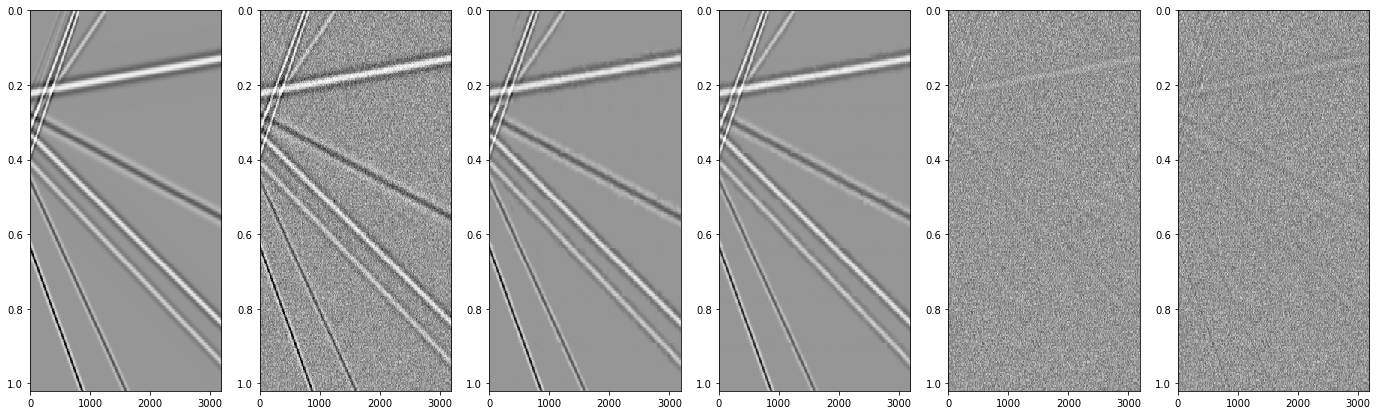

In [38]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean,orig_noisy,decodedimg_convUnet_v2_SGD,decodedimg_convUnet_v3_SGD,orig_noisy-decodedimg_convUnet_v2_SGD,orig_noisy-decodedimg_convUnet_v3_SGD],num=12)

<Figure size 1080x720 with 0 Axes>

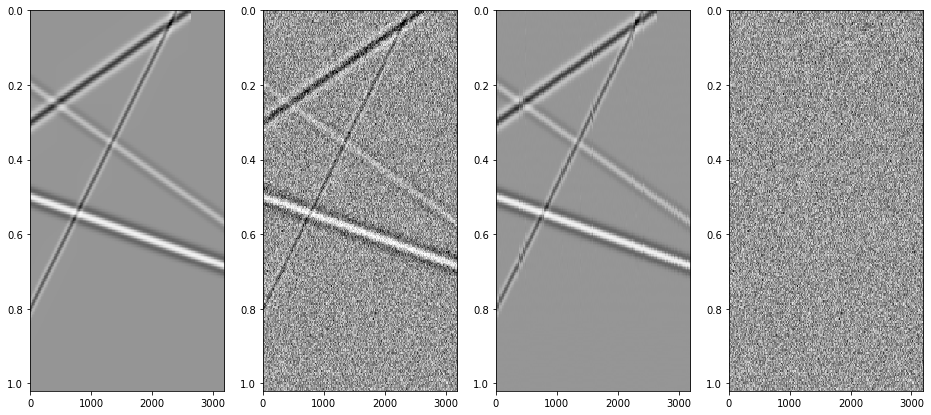

In [50]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean_p,orig_noisy_p,decodedimg_ANNtrc_SGD,orig_noisy_p-decodedimg_ANNtrc_SGD],num=4)